# TEDDY HPC Cluster Usage Analysis 

TEDDY Home Page: https://teddy.epi.usf.edu

Analysis Code: https://github.com/usf-hii/hpcreport


In [1]:
%reset -f

In [11]:
import gzip
import os
import pickle
import time
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Generate data file paths for past 6 months

In [12]:
data_base_url = 'http://depot.epi.usf.edu/report/data'
data_base_url_legacy = 'http://depot.epi.usf.edu/src/countskm/hpcreport/data'

legacy_map = {
        '2017-08-15': 0, '2017-09-01': 1, '2017-09-15': 2, '2017-10-01': 3, '2017-10-15': 4,
        '2017-11-01': 5, '2017-11-15': 6, '2017-12-01': 7, '2017-12-15': 8, '2018-01-01': 9 }

legacy_files = [
        f'{data_base_url_legacy}/sacct-2017-07.tsv.bz2', f'{data_base_url_legacy}/sacct-2017-06.tsv.bz2',
        f'{data_base_url_legacy}/sacct-2017-05.tsv.bz2', f'{data_base_url_legacy}/sacct-2017-04.tsv.bz2',
        f'{data_base_url_legacy}/sacct-2017-03.tsv.bz2', f'{data_base_url_legacy}/sacct-2017-02.tsv.bz2' ]

data_files = []

if 'DATE' in os.environ:
    today = datetime.strptime(os.environ['DATE'], '%Y-%m-%d')
else:
    today = datetime.today()

if today.day < 14:
    date = datetime(today.year, today.month, 1)
else:
    date = datetime(today.year, today.month, 15)

datestamp = date.strftime('%Y-%m-%d')

data_files.append(f'{data_base_url}/sacct/sacct-{datestamp}.tsv.gz')

if datestamp in legacy_map:
    periods = legacy_map[datestamp]
    legacy_files_to_include = int((12 - periods) / 2)
else:
    periods = 11
    legacy_files_to_include = 0

for n in range(periods):
    if date.day == 1:
        previous = date - timedelta(1)
        date = datetime(previous.year, previous.month, 15)
    else:
        date = datetime(date.year, date.month, 1)

    datestamp = date.strftime('%Y-%m-%d')

    data_files.append(f'{data_base_url}/sacct/sacct-{datestamp}.tsv.gz')


data_files.extend(legacy_files[0:legacy_files_to_include])

data_files

['http://depot.epi.usf.edu/report/data/sacct/sacct-2017-08-15.tsv.gz',
 'http://depot.epi.usf.edu/src/countskm/hpcreport/data/sacct-2017-07.tsv.bz2',
 'http://depot.epi.usf.edu/src/countskm/hpcreport/data/sacct-2017-06.tsv.bz2',
 'http://depot.epi.usf.edu/src/countskm/hpcreport/data/sacct-2017-05.tsv.bz2',
 'http://depot.epi.usf.edu/src/countskm/hpcreport/data/sacct-2017-04.tsv.bz2',
 'http://depot.epi.usf.edu/src/countskm/hpcreport/data/sacct-2017-03.tsv.bz2',
 'http://depot.epi.usf.edu/src/countskm/hpcreport/data/sacct-2017-02.tsv.bz2']

### Define time units and other static values used in analysis

In [18]:
# time units: T=minutes, H=hours

memory_max = 12000 # in gb
cores_max = 1520
sample_timeunit = '5T'
resample_timeunit = '24H'

### Define known hpc accounts and columns of job data we will process 

In [19]:
hpc_accounts = [
  'hii',
  'hiibroad',
  'hiibaylor',
  'hii-fredhutch',
  'hii-ucsd',
  'hii-ut',
  'hii-pnnl',
  'hii-uva',
  'hii-uf',
  'hii-pndri',
  'hii-um',
  'hii-upenn'
]

columns = [
  'Account',
  'AllocCPUS',
  'AllocNodes',
  'Elapsed',
  'Partition',
  'ReqMem',
  'Start',
  'End',
  'State',
  'User'
]

### Create utility functions for supplementing row data

In [20]:
# Utility functions for filtering rows

def get_elapsed_seconds(row):
    return int(pd.to_timedelta(row.Elapsed.replace('-', ' Days ')).total_seconds())
 
def memory_gb(row):
    quantity = row.ReqMem[:-2]
    unit = row.ReqMem[-2:]
    if unit == 'Mc':
        return row.AllocCPUS * float(quantity) / 1024
    elif unit == 'Mn':
        return row.AllocNodes * float(quantity) / 1024
    elif unit == 'Gc':
        return row.AllocCPUS * float(quantity) 
    elif unit == 'Gn':
        return row.AllocNodes * float(quantity)

### Read, Filter, and Transform raw job data 

In [21]:
run_start = datetime.now()

df_tmp = pd.DataFrame()

for file in data_files:
    df = pd.read_csv(file, sep='\t', usecols=columns)

    # Filter to include only hii02 production partition and hii/eap jobs
    df = df.loc[df.Partition == 'hii02']                                                                  
    df = df.loc[df.Account.str.startswith('hii')]
    
    # Filter out rows with unknown dates
    df = df.loc[df.Start != 'Unknown']                                                                  
    df = df.loc[df.End != 'Unknown']        
  
    # Add new column elapsed_seconds
    df['ElapsedSeconds'] = df.apply(get_elapsed_seconds, axis=1)
    
    # filter-out small jobs under 5 minutes
    df = df.loc[df.ElapsedSeconds > 300]
    
    # Add new column MemoryGB
    df['MemoryGB'] = df.apply(lambda row: memory_gb(row), axis=1)

    # Convert Start and End datatypes to Datetime
    df['Start'] = pd.to_datetime(df['Start'])
    df['End'] = pd.to_datetime(df['End'])

    df_tmp = pd.concat([df_tmp, df], ignore_index=True)

df = df_tmp
  
run_end = datetime.now()
run_seconds = (run_end - run_start).seconds
print('time in seconds: {seconds}'.format(seconds=run_seconds))
    
df.head()  

time in seconds: 98


,AllocCPUS,AllocNodes,Account,Elapsed,End,Partition,ReqMem,Start,State,User,ElapsedSeconds,MemoryGB
0,4,1,hii-ut,00:22:03,2017-08-01 02:03:00,hii02,63Gn,2017-08-01 01:40:57,COMPLETED,jakelin,1323,63.0
1,4,1,hii-ut,00:19:17,2017-08-01 02:00:14,hii02,63Gn,2017-08-01 01:40:57,COMPLETED,jakelin,1157,63.0
2,4,1,hii-ut,00:27:01,2017-08-02 10:54:26,hii02,63Gn,2017-08-02 10:27:25,COMPLETED,jakelin,1621,63.0
3,4,1,hii-ut,00:18:43,2017-08-01 02:26:02,hii02,63Gn,2017-08-01 02:07:19,COMPLETED,jakelin,1123,63.0
4,4,1,hii-ut,00:19:21,2017-08-01 02:26:40,hii02,63Gn,2017-08-01 02:07:19,COMPLETED,jakelin,1161,63.0


## Show first and last timestamp

In [24]:
print(df.Start.min())
print(df.End.max())

2017-01-30 11:35:29
2017-08-15 04:42:05


### Calculate number of job entries after filtering 

In [25]:
len(df)

132935

### Set account information

In [26]:
accounts = set(hpc_accounts + list(df.Account.unique()))
accounts

{'hii',
 'hii-fredhutch',
 'hii-pndri',
 'hii-pnnl',
 'hii-ucsd',
 'hii-uf',
 'hii-um',
 'hii-upenn',
 'hii-ut',
 'hii-uva',
 'hiibaylor',
 'hiibroad',
 'hiiuva'}

### Establish timeframe using first job's start time and last jobs end time as the range

In [27]:
datestamp_min = df.Start.min().round(sample_timeunit)
datestamp_max = df.End.max().round(sample_timeunit)
(datestamp_min, datestamp_max)

(Timestamp('2017-01-30 11:35:00'), Timestamp('2017-08-15 04:40:00'))

### Create a time series index to be used in our time buckets to record allocation every N minutes 

In [28]:
time_index = pd.date_range(datestamp_min, datestamp_max, freq=sample_timeunit)
time_index[0:5] # sample of first 5 entries for illustrative purposes

DatetimeIndex(['2017-01-30 11:35:00', '2017-01-30 11:40:00', '2017-01-30 11:45:00', '2017-01-30 11:50:00', '2017-01-30 11:55:00'], dtype='datetime64[ns]', freq='5T')

### Create the "time buckets" which will record per-institution allocation of core/memgb resources

In [29]:
cores_bucket = pd.DataFrame(0, columns=accounts, index=time_index) 
memgb_bucket = pd.DataFrame(0, columns=accounts, index=time_index) 

### Populate the time buckets using filtered job data

In [30]:
run_start = datetime.now()

for row in df.itertuples():
    start = row.Start.round(sample_timeunit)
    end = row.End.round(sample_timeunit)
    cores_bucket.loc[start:end,[row.Account]] += row.AllocCPUS
    memgb_bucket.loc[start:end,[row.Account]] += row.MemoryGB
        
run_end = datetime.now()
run_seconds = (run_end - run_start).seconds
print('time in seconds: {seconds}'.format(seconds=run_seconds))

time in seconds: 442


In [31]:
cores_bucket.head()

,hii-upenn,hii-pndri,hii-um,hiiuva,hii-uf,hii-ucsd,hiibaylor,hii-pnnl,hii-uva,hiibroad,hii-fredhutch,hii,hii-ut
2017-01-30 11:35:00,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-01-30 11:40:00,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-01-30 11:45:00,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-01-30 11:50:00,0,0,0,1,0,0,0,0,0,0,0,0,0
2017-01-30 11:55:00,0,0,0,1,0,0,0,0,0,0,0,0,0


In [32]:
memgb_bucket.head()

,hii-upenn,hii-pndri,hii-um,hiiuva,hii-uf,hii-ucsd,hiibaylor,hii-pnnl,hii-uva,hiibroad,hii-fredhutch,hii,hii-ut
2017-01-30 11:35:00,0,0,0,4.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0
2017-01-30 11:40:00,0,0,0,4.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0
2017-01-30 11:45:00,0,0,0,4.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0
2017-01-30 11:50:00,0,0,0,4.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0
2017-01-30 11:55:00,0,0,0,4.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0


### Combined allocation of all Institutions

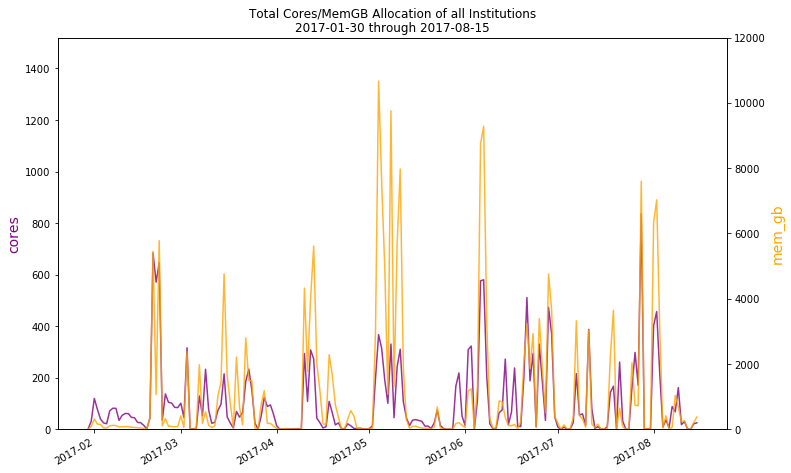

In [33]:
fig = plt.figure(figsize=(12,8), facecolor='white')
ax_cores = fig.add_subplot(111)
ax_memgb = ax_cores.twinx()
    
ax_cores.set_ylim(ymax=cores_max)
ax_memgb.set_ylim(ymax=memory_max)

ax_cores.set_ylabel('cores', fontsize=14, color='purple') 
ax_memgb.set_ylabel('mem_gb', fontsize=14, color='orange')
                 
ax_cores.plot(cores_bucket.sum(axis=1).resample(resample_timeunit).mean(), color='purple', alpha=0.8)
ax_memgb.plot(memgb_bucket.sum(axis=1).resample(resample_timeunit).mean(), color='orange', alpha=0.8)

plt.title('Total Cores/MemGB Allocation of all Institutions\n{start} through {end}'.format(
    start=datestamp_min.date(), end=datestamp_max.date()))
fig.autofmt_xdate() 

### Allocation of HII only

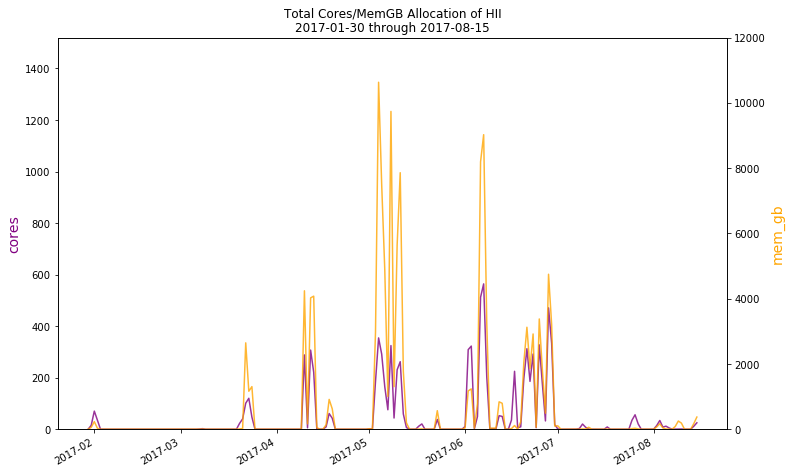

In [34]:
fig = plt.figure(figsize=(12,8), facecolor='white')
ax_cores = fig.add_subplot(111)
ax_memgb = ax_cores.twinx()
    
ax_cores.set_ylim(ymax=cores_max)
ax_memgb.set_ylim(ymax=memory_max)

ax_cores.set_ylabel('cores', fontsize=14, color='purple') 
ax_memgb.set_ylabel('mem_gb', fontsize=14, color='orange')

ax_cores.set_ylabel('cores', fontsize=14) 
ax_memgb.set_ylabel('mem_gb', fontsize=14)

ax_cores.plot(cores_bucket['hii'].resample(resample_timeunit).mean(), color='purple', alpha=0.8, label='cores')
ax_memgb.plot(memgb_bucket['hii'].resample(resample_timeunit).mean(), color='orange', alpha=0.8, label='memgb')

fig.autofmt_xdate() 
plt.title('Total Cores/MemGB Allocation of HII\n{start} through {end}'.format(
    start=datestamp_min.date(), end=datestamp_max.date()));


### Allocation of all Institutions except HII

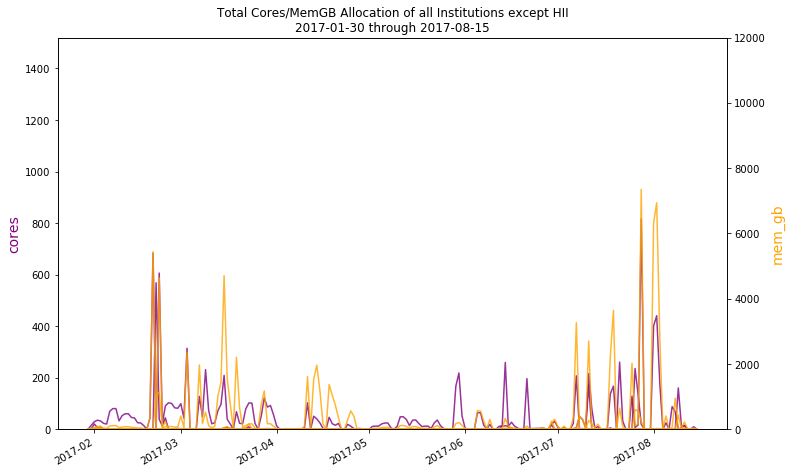

In [35]:
fig = plt.figure(figsize=(12,8), facecolor='white')
ax_cores = fig.add_subplot(111)
ax_memgb = ax_cores.twinx()
    
ax_cores.set_ylim(ymax=cores_max)
ax_memgb.set_ylim(ymax=memory_max)

ax_cores.set_ylabel('cores', fontsize=14, color='purple') 
ax_memgb.set_ylabel('mem_gb', fontsize=14, color='orange')

ax_cores.set_ylabel('cores', fontsize=14) 
ax_memgb.set_ylabel('mem_gb', fontsize=14)

ax_cores.plot(cores_bucket.loc[:, cores_bucket.columns != 'hii'].resample(resample_timeunit).mean(), color='purple', alpha=0.8, label='cores')
ax_memgb.plot(memgb_bucket.loc[:, memgb_bucket.columns != 'hii'].resample(resample_timeunit).mean(), color='orange', alpha=0.8, label='memgb')


plt.title('Total Cores/MemGB Allocation of all Institutions except HII\n{start} through {end}'.format(
    start=datestamp_min.date(), end=datestamp_max.date()))
fig.autofmt_xdate() 

### Graph % Allocation by Institution (sum equals 100%)

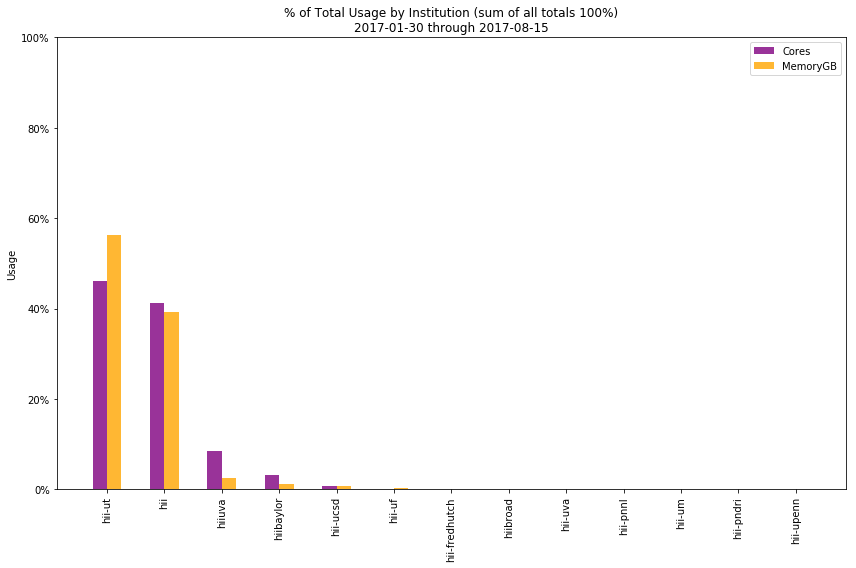

In [36]:
by_inst_cores = cores_bucket.sum().sort_values(ascending=False).values
by_inst_cores_total = cores_bucket.sum().sum()

by_inst_cores = [x/by_inst_cores_total for x in by_inst_cores]

by_inst_cores

by_inst_memory = memgb_bucket.sum().sort_values(ascending=False).values
by_inst_memory_total = memgb_bucket.sum().sum()

by_inst_memory = [x/by_inst_memory_total for x in by_inst_memory]
by_inst_memory

inst_names = cores_bucket.sum().sort_values(ascending=False).keys()

index = np.arange(len(inst_names))

bar_width = 0.25

by_inst_cores = cores_bucket.sum().sort_values(ascending=False).values
by_inst_cores_total = cores_bucket.sum().sum()

by_inst_cores = [x/by_inst_cores_total for x in by_inst_cores]

by_inst_cores

by_inst_memory = memgb_bucket.sum().sort_values(ascending=False).values
by_inst_memory_total = memgb_bucket.sum().sum()

by_inst_memory = [x/by_inst_memory_total for x in by_inst_memory]
by_inst_memory

inst_names = cores_bucket.sum().sort_values(ascending=False).keys()

index = np.arange(len(inst_names))

bar_width = 0.25

fig = plt.figure(figsize=(12,8), facecolor='white')
ax = fig.add_subplot(111)

rects1 = ax.bar(index, by_inst_cores, bar_width, color='purple', label='Cores', alpha= 0.8)
rects2 = ax.bar(index + bar_width, by_inst_memory, bar_width, color='orange', label='MemoryGB', alpha= 0.8)

plt.ylabel('Usage')
plt.title('% of Total Usage by Institution (sum of all totals 100%)\n{start} through {end}'.format(
    start=datestamp_min.date(), end=datestamp_max.date()))

plt.xticks(index + bar_width/2, inst_names, rotation=90)
plt.legend()

formatter = matplotlib.ticker.FuncFormatter(lambda y, pos: "%d%%" % (y*100))
ax.yaxis.set_major_formatter(formatter)
ax.set_ylim(ymax=1)

plt.tight_layout()

In [37]:
cores_bucket.sum().sort_values(ascending=False).values
foox = cores_bucket.sum().sort_values(ascending=False)
foox.keys()

Index(['hii-ut', 'hii', 'hiiuva', 'hiibaylor', 'hii-ucsd', 'hii-uf', 'hii-fredhutch', 'hiibroad', 'hii-uva', 'hii-pnnl', 'hii-um', 'hii-pndri', 'hii-upenn'], dtype='object')

### Calculate statistics

In [39]:
max_memgb_allocated = int(memgb_bucket.sum(axis=1).resample(resample_timeunit).mean().max())
min_memgb_allocated = int(memgb_bucket.sum(axis=1).resample(resample_timeunit).mean().min())
max_cores_allocated = int(cores_bucket.sum(axis=1).resample(resample_timeunit).mean().max())
min_cores_allocated = int(cores_bucket.sum(axis=1).resample(resample_timeunit).mean().min())
mean_memgb_allocated = int(memgb_bucket.sum(axis=1).resample(resample_timeunit).mean().mean())
mean_cores_allocated = int(cores_bucket.sum(axis=1).resample(resample_timeunit).mean().mean())
average_job_time_minutes = int(df.ElapsedSeconds.mean() / 60)

print('Timeframe: {start} through {end}\n'.format(
    start=datestamp_min.date(), end=datestamp_max.date()))

print('Total Cores:                 {}'.format(cores_max))
print('Total Memory GB:             {}'.format(memory_max))
print()



print('Cores Allocated (Mean):      {}'.format(mean_cores_allocated))
print('Cores Allocated (Maximum):   {}\n'.format(max_cores_allocated))

print('MemoryGB Allocated (Mean):   {}'.format(mean_memgb_allocated))
print('Memory GB Allocated (Max):   {}\n'.format(max_memgb_allocated))

print('Job Time in Minutes (Mean):  {}\n'.format(average_job_time_minutes))

print('Total Jobs Run:              {}'.format(len(df.index)))

Timeframe: 2017-01-30 through 2017-08-15

Total Cores:                 1520
Total Memory GB:             12000

Cores Allocated (Mean):      103
Cores Allocated (Maximum):   835

MemoryGB Allocated (Mean):   1120
Memory GB Allocated (Max):   10659

Job Time in Minutes (Mean):  72

Total Jobs Run:              132935


### Display jobs run by Institution

In [40]:
df_by_account = df.groupby('Account')

jobs_by_institution = df_by_account['Partition'].count().sort_values(ascending=False)

print(jobs_by_institution.to_string())

Account
hii-ut       66695
hii          63725
hiiuva        1689
hiibaylor      686
hii-ucsd        78
hii-uf          62
